In [1]:
import os
import json
from pprint import pprint
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import statsmodels.api as sm
import numpy as np
import datetime as dt


#Put all movie data into a list of dictionaries
def movie_data(movie_file):
    movie_info_path = os.path.join('../data', movie_file)
    json_movie_list = os.listdir(movie_info_path)
    python_movie_list = []
    for json_movie in json_movie_list:
        json_path = os.path.join(movie_info_path, json_movie)
        with open(json_path, 'r') as file:
            python_movie = json.load(file)
            python_movie_list.append(python_movie)
    return python_movie_list

mojo = movie_data('boxofficemojo')
metacritic = movie_data('metacritic')

metacritic_clean = [item for item in metacritic if isinstance(item, dict)]

mojo_df = pd.DataFrame(mojo)
metacritic_df = pd.DataFrame(metacritic_clean)

merged_data = pd.merge(left=mojo_df, right=metacritic_df, how='inner', on=['title'])

def consolodate_director(col_x, col_y):
    director = []
    for i in xrange(len(col_x)):
        if col_x[i] == None:
            director.append(col_y[i])
        if col_y[i] == None:
            director.append(col_x[i])
        director.append(col_x[i])
    return pd.Series(director)

def review_breakdown(review_col, index):
    lst = []
    for group in review_col:
        lst.append(group[index])
    return pd.Series(lst)

def season_by_month(month):
    if month in (12,1,2):
      return 'winter'
    elif month in (3,4,5):
      return 'spring'
    elif month in (6,7,8):
      return 'summer'
    elif month in (9,10,11):
      return 'fall'

def group_ratings(rating):
    if rating not in ('R','PG','PG-13','Not Rated'):
        return 'other'
    else:
        return rating

merged_data['director'] = consolodate_director(merged_data['director_x'], merged_data['director_y'])
merged_data['rating_categories'] = merged_data['rating'].apply(group_ratings)
merged_data['pos_user_reviews'] = review_breakdown(merged_data['num_user_reviews'], 0)
merged_data['nut_user_reviews'] = review_breakdown(merged_data['num_user_reviews'], 1)
merged_data['neg_user_reviews'] = review_breakdown(merged_data['num_user_reviews'], 2)
merged_data['tot_user_reviews'] = review_breakdown(merged_data['num_user_reviews'], 3)
merged_data['pos_critic_reviews'] = review_breakdown(merged_data['num_critic_reviews'], 0)
merged_data['nut_critic_reviews'] = review_breakdown(merged_data['num_critic_reviews'], 1)
merged_data['neg_critic_reviews'] = review_breakdown(merged_data['num_critic_reviews'], 2)
merged_data['tot_critic_reviews'] = review_breakdown(merged_data['num_critic_reviews'], 3)

merged_data.rename(columns={'year_x':'year'}, inplace=True)

del merged_data['year_y']
del merged_data['director_x']
del merged_data['director_y']

merged_data_dropna = merged_data[['production_budget','opening_weekend_take','domestic_gross',
                                  'release_date_wide','widest_release','worldwide_gross','year', 'runtime_minutes',
                                  'metascore','user_score','pos_user_reviews','nut_user_reviews','neg_user_reviews',
                                  'tot_user_reviews','pos_critic_reviews','nut_critic_reviews','neg_critic_reviews',
                                  'tot_critic_reviews','rating','rating_categories']].dropna()

merged_data_dropna['release_month'] = merged_data_dropna['release_date_wide'].apply(lambda x: x[5:7]).astype(int)
merged_data_dropna['season'] = merged_data_dropna['release_month'].apply(season_by_month)

In [2]:
import holidays
from collections import Counter
import datetime

In [3]:
def gen_holiday(end_yr):
    us_hol = []
    for yr in range(1900,end_yr):
        for date in sorted(holidays.US(years=yr).items()):
            us_hol.append(date[0])
    return us_hol

In [4]:
us_holidays = gen_holiday(2015)

In [5]:
def make_date(dt_str):
    if dt_str == None:
        dt_conv = datetime.date(2014,1,3)
    else:
        dt_conv = datetime.date(int(dt_str[0:4]),int(dt_str[5:7]),int(dt_str[8:10]))
    return dt_conv

In [7]:
def hol_weekend(release_date):
    if make_date(release_date) in us_holidays:
        return 1
    elif make_date(release_date) + datetime.timedelta(days=1) in us_holidays:
        return 1
    elif make_date(release_date) + datetime.timedelta(days=2) in us_holidays:
        return 1
    elif make_date(release_date) + datetime.timedelta(days=3) in us_holidays:
        return 1
    elif make_date(release_date) + datetime.timedelta(days=4) in us_holidays:
        return 1
    elif make_date(release_date) + datetime.timedelta(days=5) in us_holidays:
        return 1
    else:
        return 0

In [8]:
# M == 0
def day_of_week(release_date):
    dt_conv = make_date(release_date)
    return dt_conv.weekday()        

In [9]:
merged_data['holiday_weekend'] = merged_data['release_date_wide'].apply(hol_weekend)

In [10]:
merged_data['day_of_week'] = merged_data['release_date_wide'].apply(day_of_week)

In [12]:
merged_data.loc[lambda df: df.holiday_weekend == True, :].head()

KeyError: 'the label [<function <lambda> at 0x118c2de60>] is not in the [index]'

In [11]:
merged_data_dropna = merged_data[['production_budget','opening_weekend_take','domestic_gross',
                                  'release_date_wide','widest_release','worldwide_gross','year', 'runtime_minutes',
                                  'metascore','user_score','pos_user_reviews','nut_user_reviews','neg_user_reviews',
                                  'tot_user_reviews','pos_critic_reviews','nut_critic_reviews','neg_critic_reviews',
                                  'tot_critic_reviews','rating','rating_categories','holiday_weekend','day_of_week']].dropna()
merged_data_dropna['release_month'] = merged_data_dropna['release_date_wide'].apply(lambda x: x[5:7]).astype(int)
merged_data_dropna['season'] = merged_data_dropna['release_month'].apply(season_by_month)

In [12]:
merged_data_dropna['widest_release_sq'] = merged_data_dropna['widest_release'].apply(lambda X:np.log(X))
merged_data_dropna['holiday_weekend_sq'] = merged_data_dropna['holiday_weekend'].apply(lambda X:X**3)
merged_data_dropna['production_budget_sq'] = merged_data_dropna['production_budget'].apply(lambda X:X**2)
merged_data_dropna['runtime_minutes_sq'] = merged_data_dropna['runtime_minutes'].apply(lambda X:X**2)
merged_data_dropna['metascore_sq'] = merged_data_dropna['metascore'].apply(lambda X:X**2)

In [13]:
msk = np.random.rand(len(merged_data_dropna)) < 1
train = merged_data_dropna[msk]
test = merged_data_dropna[~msk]

In [15]:
X = sm.add_constant(train[['production_budget','runtime_minutes','holiday_weekend','day_of_week','production_budget_sq',
                                               'runtime_minutes_sq','metascore_sq',
                                            'widest_release_sq','holiday_weekend_sq','widest_release','metascore']].join(
                                            pd.get_dummies(train['season']).join(
                                            pd.get_dummies(train['rating_categories']))))
Y = train['opening_weekend_take']

linmodel = sm.OLS(Y,X).fit()

linmodel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     opening_weekend_take   R-squared:                       0.554
Model:                              OLS   Adj. R-squared:                  0.552
Method:                   Least Squares   F-statistic:                     349.3
Date:                  Fri, 12 Aug 2016   Prob (F-statistic):          1.64e-195
Time:                          13:06:10   Log-Likelihood:                -20063.
No. Observations:                  1131   AIC:                         4.014e+04
Df Residuals:                      1126   BIC:                         4.016e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                -2546.1224    290.187     -8.774      0.000     -3115.490 -1976.755
production_budget       -0.0491      0.031     -1.582      0.114        -0.110     0.012
runtime_minutes      -1.788e+05   2.04e+04     -8.775      0.000     -2.19e+05 -1.39e+05
holiday_weekend       -364.4145     41.525     -8.776      0.000      -445.889  -282.940
day_of_week          -1.013e+04   1154.241     -8.774      0.000     -1.24e+04 -7862.759
production_budget_sq   1.05e-09    1.7e-10      6.189      0.000      7.17e-10  1.38e-09
runtime_minutes_sq     679.9333    124.856      5.446      0.000       434.957   924.909
metascore_sq          2032.2689    242.047      8.396      0.000      1557.355  2507.183
widest_release_sq    -1.397e+04   1592.817     -8.770      0.000     -1.71e+04 -1.08e+04
holiday_weekend_sq    -364.4145     41.525     -8.776      0.000      -445.889  -282.940
widest_release            1e+04    485.149     20.613      0.000      9048.696   1.1e+04
metascore            -6.758e+04   7702.614     -8.774      0.000     -8.27e+04 -5.25e+04
fall                  -678.3283     77.318     -8.773      0.000      -830.032  -526.625
spring                -763.3375     87.000     -8.774      0.000      -934.037  -592.638
summer                -544.8334     62.108     -8.772      0.000      -666.693  -422.974
winter                -559.6233     63.761     -8.777      0.000      -684.728  -434.519
Not Rated               79.0490      9.006      8.778      0.000        61.379    96.719
PG                    -170.5232     19.481     -8.753      0.000      -208.746  -132.300
PG-13                 -949.0103    108.168     -8.773      0.000     -1161.244  -736.776
R                    -1375.1685    156.666     -8.778      0.000     -1682.559 -1067.778
other                 -130.4694     14.877     -8.770      0.000      -159.659  -101.280
==============================================================================
Omnibus:                      741.103   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15604.153
Skew:                           2.676   Prob(JB):                         0.00
Kurtosis:                      20.392   Cond. No.                     1.54e+32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.07e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [16]:
train_pred = pd.DataFrame(linmodel.predict(X),index=train.index)
final = pd.concat([train_pred,Y,X],axis=1)
final

,0,opening_weekend_take,const,production_budget,runtime_minutes,holiday_weekend,day_of_week,production_budget_sq,runtime_minutes_sq,metascore_sq,...,metascore,fall,spring,summer,winter,Not Rated,PG,PG-13,R,other
0,1.672663e+07,8330681.0,1,30000000.0,97.0,0,2,9.000000e+14,9409.0,4900.0,...,70.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5.795839e+06,2136801.0,1,18000000.0,94.0,0,4,3.240000e+14,8836.0,6724.0,...,82.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,2.574698e+07,21054283.0,1,37000000.0,98.0,0,4,1.369000e+15,9604.0,3249.0,...,57.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,1.935767e+07,20617667.0,1,25000000.0,104.0,0,4,6.250000e+14,10816.0,4096.0,...,64.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
11,5.673613e+07,65237614.0,1,200000000.0,158.0,0,4,4.000000e+16,24964.0,2401.0,...,49.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,-4.594199e+06,113074.0,1,12000000.0,129.0,0,4,1.440000e+14,16641.0,6084.0,...,78.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14,1.865909e+07,24105943.0,1,35000000.0,123.0,0,4,1.225000e+15,15129.0,2304.0,...,48.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15,1.639402e+07,8754168.0,1,13000000.0,93.0,0,4,1.690000e+14,8649.0,1156.0,...,34.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16,-3.076418e+06,274454.0,1,20000000.0,124.0,0,4,4.000000e+14,15376.0,4900.0,...,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17,2.470945e+07,36302612.0,1,42000000.0,109.0,0,4,1.764000e+15,11881.0,4761.0,...,69.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
X = sm.add_constant(test[['production_budget','runtime_minutes','holiday_weekend',
                           'widest_release_sq','holiday_weekend_sq','day_of_week','widest_release','metascore']].join(
                                            pd.get_dummies(test['season']).join(
                                            pd.get_dummies(test['rating_categories']))))
Y = test['opening_weekend_take']

In [21]:
test_pred = pd.DataFrame(linmodel.predict(X),index=test.index)

ValueError: shapes (0,9) and (21,) not aligned: 9 (dim 1) != 21 (dim 0)

In [19]:
final = pd.concat([test_pred,Y,X],axis=1)

NameError: name 'test_pred' is not defined

In [244]:
final['diff'] = final[0] - final['opening_weekend_take']

In [245]:
final

,0,opening_weekend_take,const,production_budget,runtime_minutes,holiday_weekend,widest_release_sq,holiday_weekend_sq,day_of_week,widest_release,...,fall,spring,summer,winter,Not Rated,PG,PG-13,R,other,diff
15,6.057528e+07,8754168.0,1,13000000.0,93.0,0,7.926964,0,4,2771.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.182111e+07
16,2.901233e+07,274454.0,1,20000000.0,124.0,0,6.018593,0,4,411.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.873787e+07
17,7.578342e+07,36302612.0,1,42000000.0,109.0,0,8.054523,0,4,3148.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.948081e+07
18,2.780529e+07,108865.0,1,5000000.0,135.0,0,6.204558,0,3,495.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.769642e+07
19,6.172319e+07,23007725.0,1,30000000.0,111.0,1,8.030735,1,4,3074.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.871547e+07
27,5.655411e+07,7160521.0,1,62000000.0,125.0,0,7.841886,0,4,2545.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.939359e+07
30,6.582604e+07,13330118.0,1,28000000.0,83.0,0,7.968320,0,4,2888.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.249593e+07
36,6.719046e+07,9910310.0,1,175000000.0,118.0,1,7.897296,1,2,2690.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.728015e+07
47,5.387585e+07,10740446.0,1,30000000.0,79.0,0,7.630461,0,2,2060.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.313540e+07
61,7.130928e+07,21157730.0,1,50200000.0,99.0,0,7.954021,0,4,2847.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.015155e+07


In [20]:
X = sm.add_constant(train[['production_budget',
                                            'widest_release_sq','widest_release','metascore']].join(
                                            pd.get_dummies(train['season'])[['spring','summer']].join(
                                            pd.get_dummies(train['rating_categories'])[['PG-13','R','other']])))
Y = train['opening_weekend_take']

linmodel = sm.OLS(Y,X).fit()

linmodel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     opening_weekend_take   R-squared:                       0.592
Model:                              OLS   Adj. R-squared:                  0.588
Method:                   Least Squares   F-statistic:                     144.8
Date:                  Fri, 12 Aug 2016   Prob (F-statistic):          3.20e-168
Time:                          10:17:08   Log-Likelihood:                -16054.
No. Observations:                   909   AIC:                         3.213e+04
Df Residuals:                       899   BIC:                         3.218e+04
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              5.307e+06   4.49e+06      1.181      0.238     -3.51e+06  1.41e+07
production_budget     0.1028      0.012      8.683      0.000         0.080     0.126
widest_release_sq -5.768e+06    7.6e+05     -7.585      0.000     -7.26e+06 -4.28e+06
widest_release     1.488e+04    875.449     17.001      0.000      1.32e+04  1.66e+04
metascore          1.695e+05   2.29e+04      7.389      0.000      1.24e+05  2.15e+05
spring             2.722e+06    9.7e+05      2.807      0.005      8.19e+05  4.62e+06
summer             3.208e+06   9.23e+05      3.477      0.001       1.4e+06  5.02e+06
PG-13              5.331e+06   1.15e+06      4.617      0.000      3.07e+06   7.6e+06
R                  4.442e+06   1.17e+06      3.782      0.000      2.14e+06  6.75e+06
other              5.798e+06   1.57e+06      3.697      0.000      2.72e+06  8.88e+06
==============================================================================
Omnibus:                      630.797   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15959.220
Skew:                           2.798   Prob(JB):                         0.00
Kurtosis:                      22.750   Cond. No.                     7.74e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.74e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

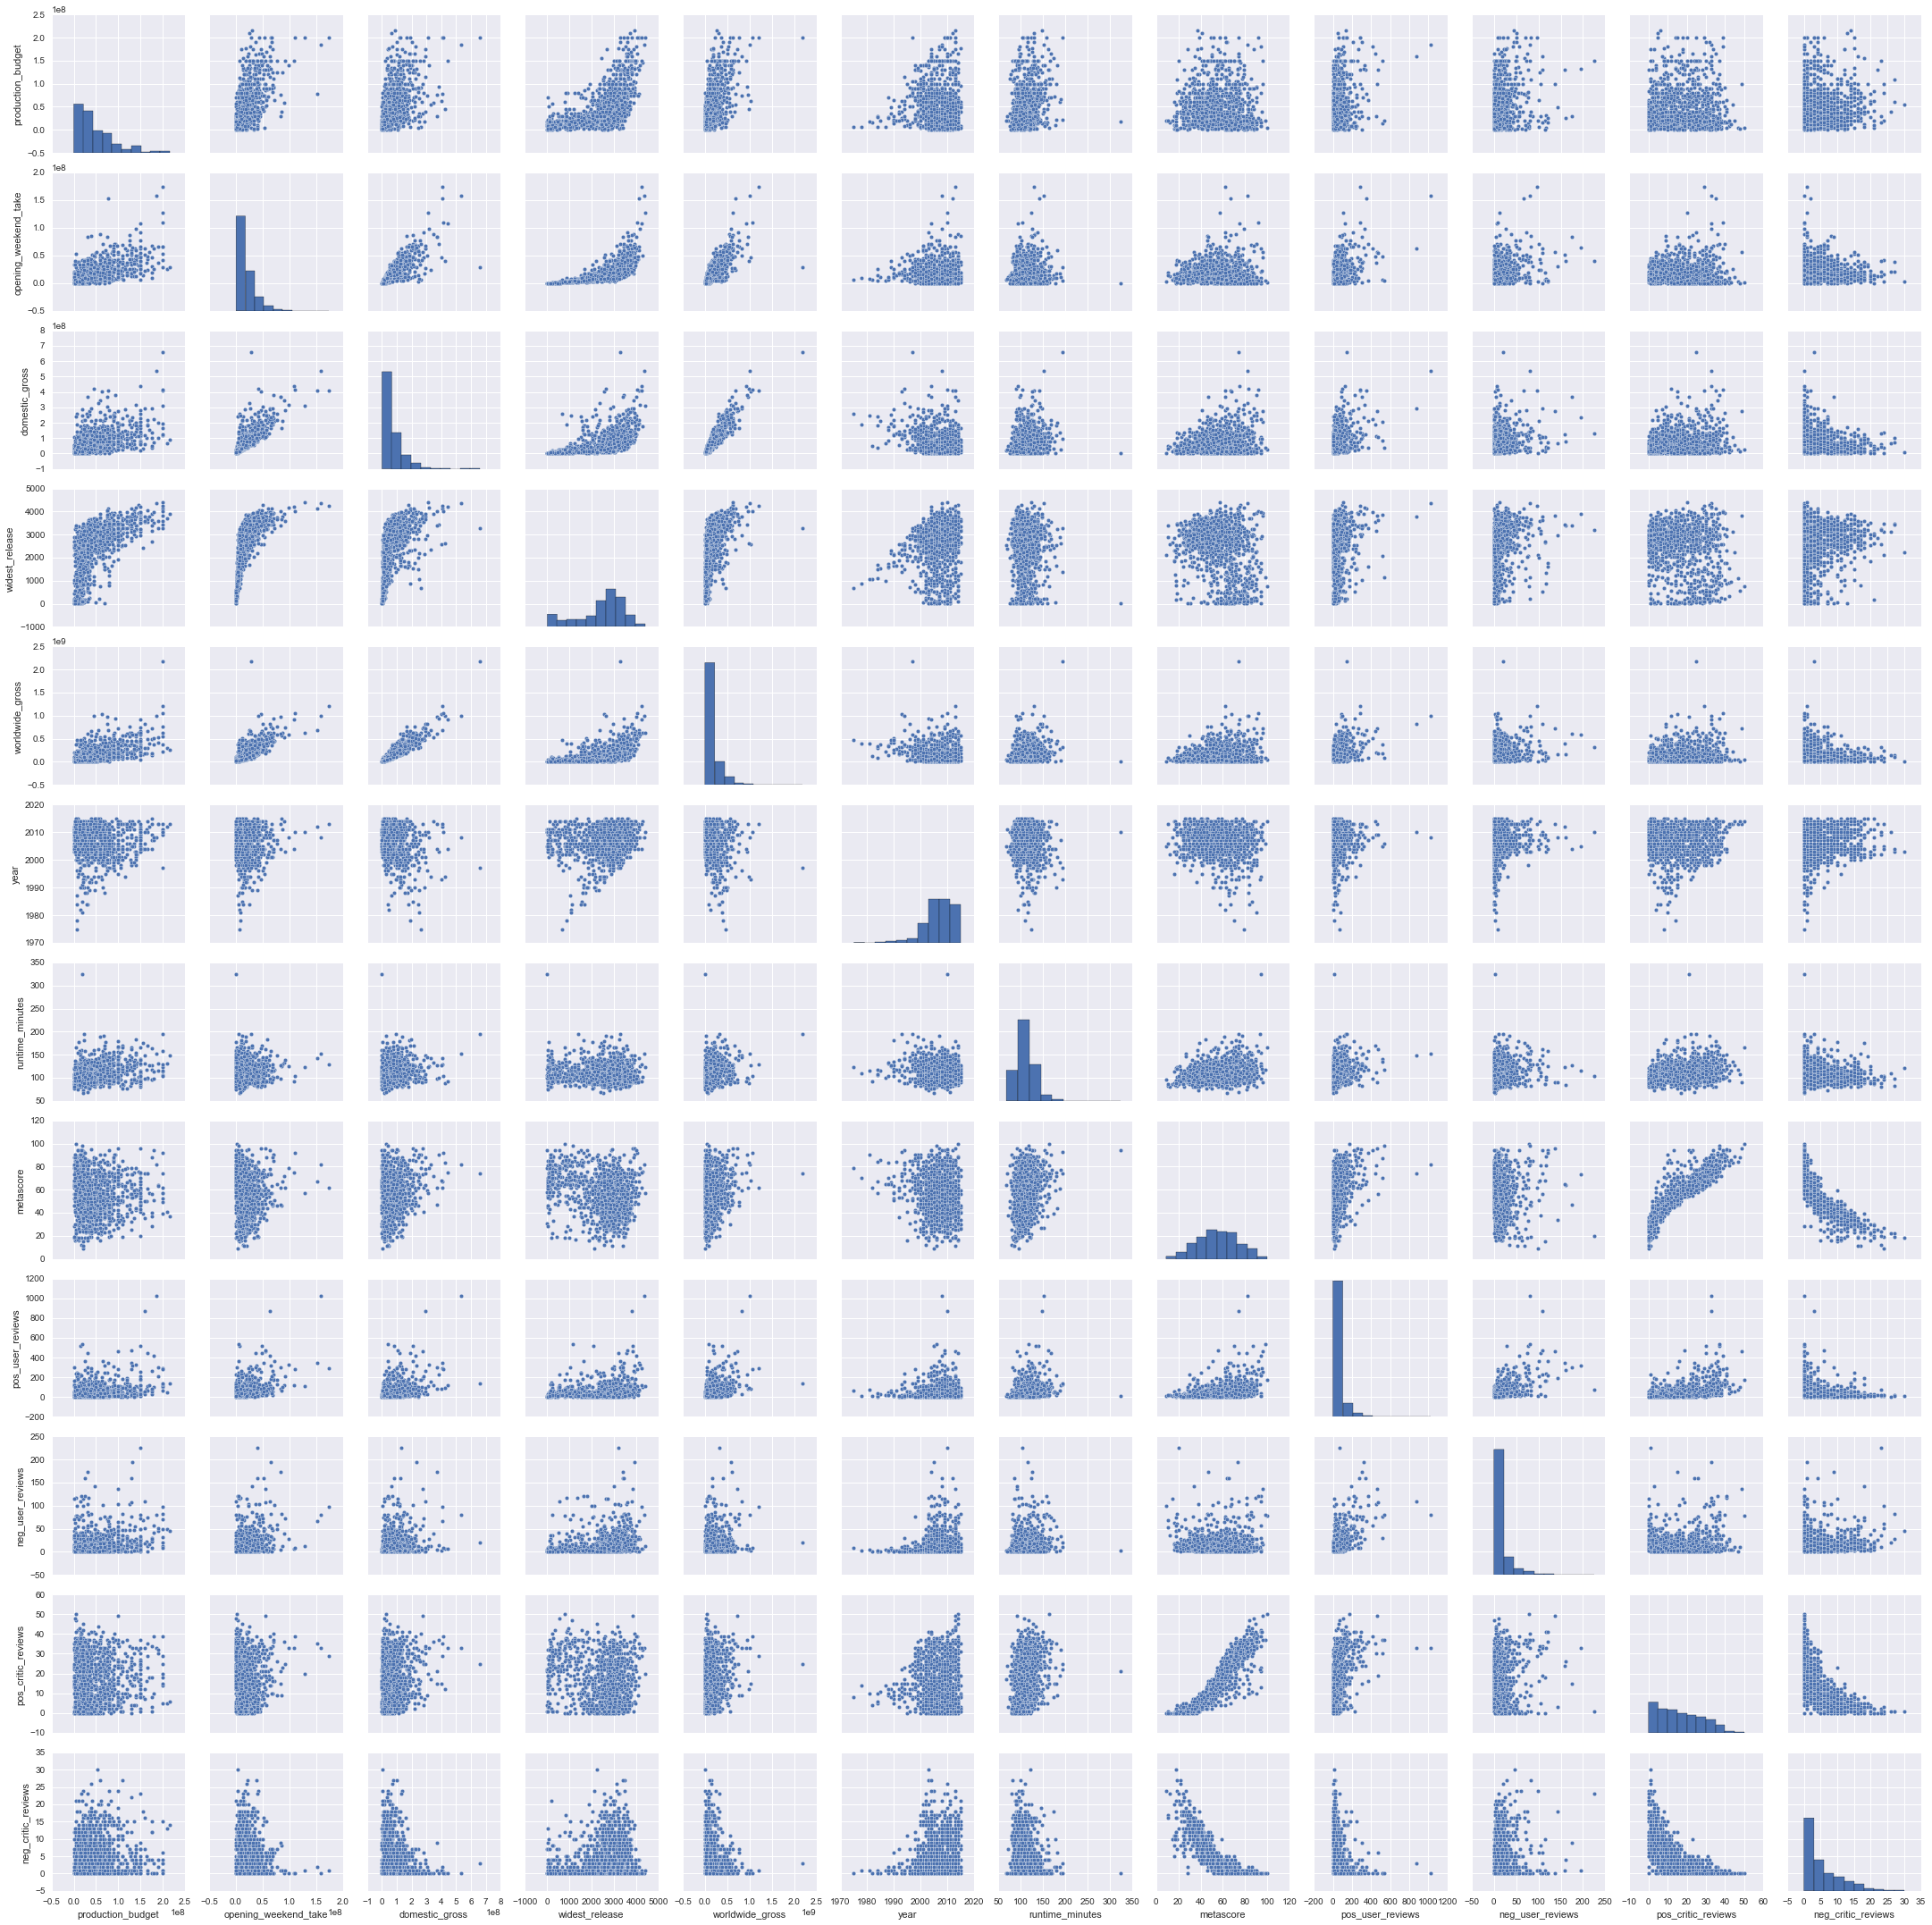

In [22]:
merged_data_dropna = merged_data[['production_budget','opening_weekend_take','domestic_gross',
                                  'release_date_wide','widest_release','worldwide_gross','year', 'runtime_minutes',
                                  'metascore','user_score','pos_user_reviews','neg_user_reviews',
                                  'pos_critic_reviews','neg_critic_reviews',
                                  'rating_categories']].dropna()

sns.pairplot(merged_data_dropna)

1131


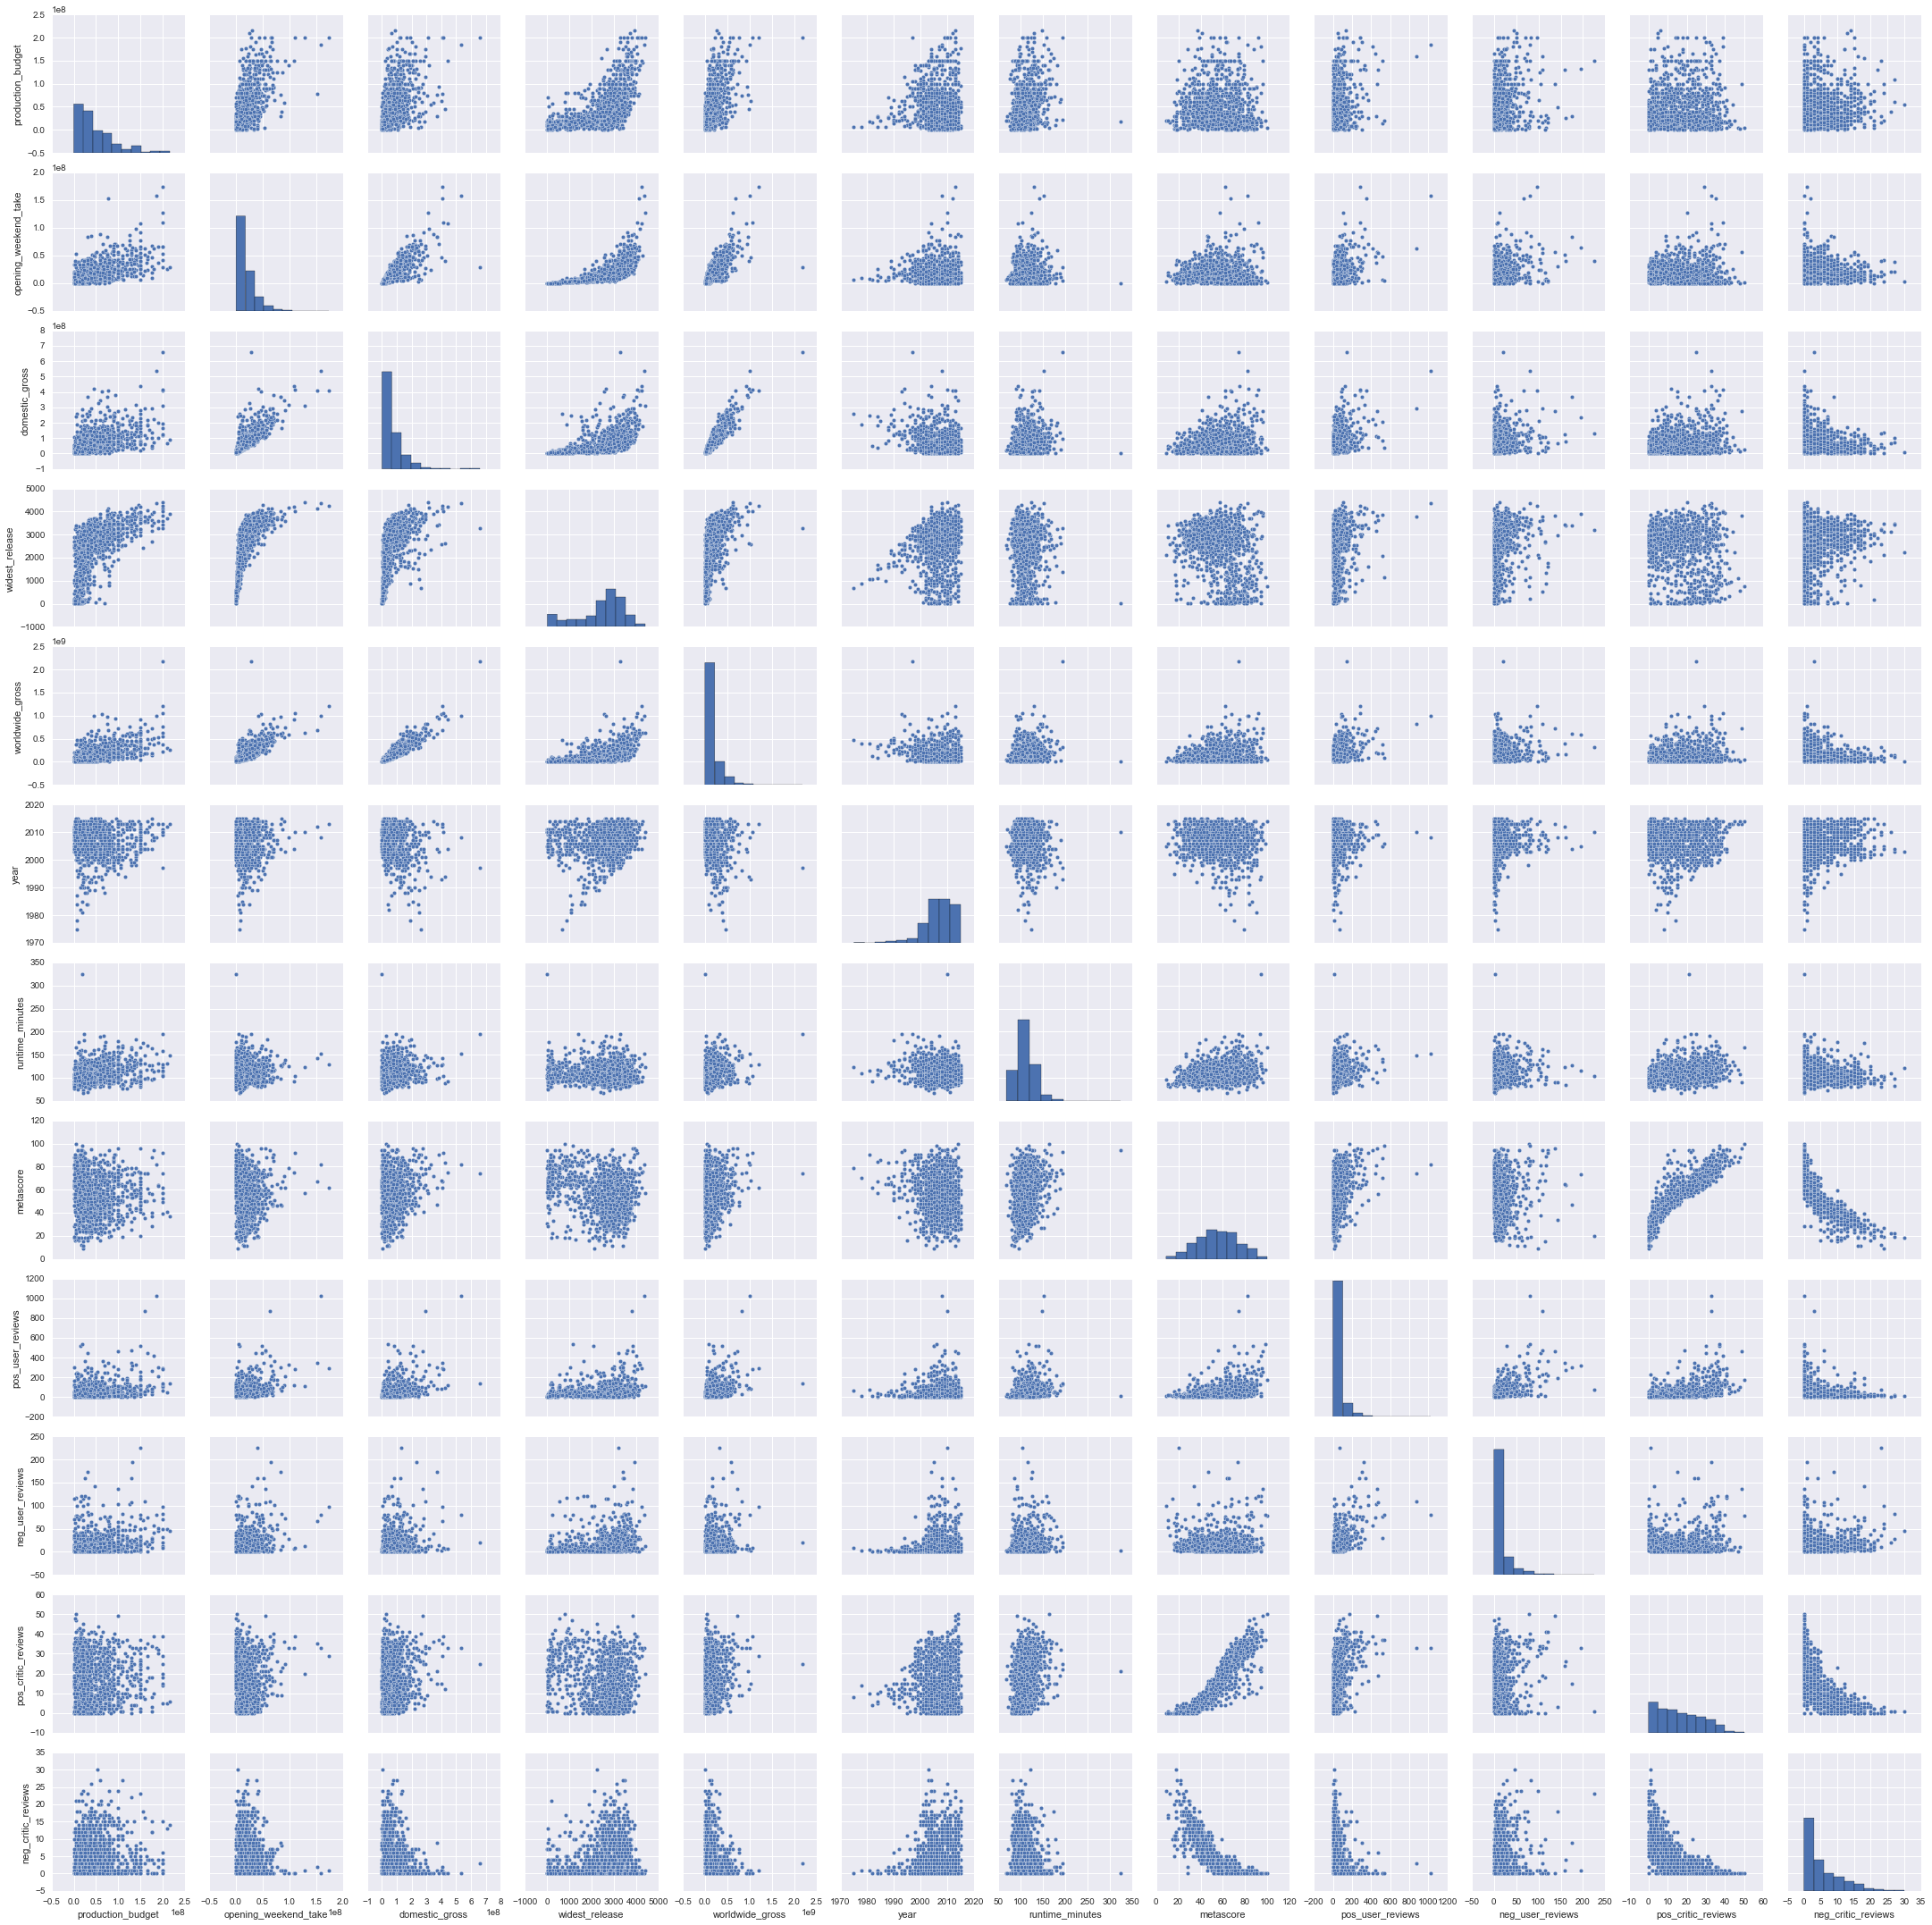

In [24]:
merged_data_dropna = merged_data[['production_budget','opening_weekend_take','domestic_gross',
                                  'release_date_wide','widest_release','worldwide_gross','year', 'runtime_minutes',
                                  'metascore','user_score','pos_user_reviews','neg_user_reviews',
                                  'pos_critic_reviews','neg_critic_reviews',
                                  'rating_categories']].dropna()

print(len(merged_data_dropna))
sns.pairplot(merged_data_dropna)

In [23]:
msk = np.random.rand(len(merged_data_dropna)) < .8
train = merged_data_dropna[msk]
test = merged_data_dropna[~msk]

In [27]:
X = sm.add_constant(train[['production_budget','runtime_minutes','holiday_weekend','day_of_week','competitors',
                                            'widest_release_sq','holiday_weekend_sq','widest_release','metascore']].join(
                                            pd.get_dummies(train['season']).join(
                                            pd.get_dummies(train['rating_categories']))))
Y = train['opening_weekend_take']

linmodel = sm.OLS(Y,X).fit()

linmodel.summary()

KeyError: "['holiday_weekend' 'day_of_week' 'competitors' 'widest_release_sq'\n 'holiday_weekend_sq'] not in index"

In [71]:
X = sm.add_constant(train[['production_budget','competitors',
                                            'widest_release_sq','widest_release','metascore']].join(
                                            pd.get_dummies(train['season'])[['spring','summer']].join(
                                            pd.get_dummies(train['rating_categories'])[['PG-13','R','other']])))
Y = train['opening_weekend_take']

linmodel = sm.OLS(Y,X).fit()

linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     opening_weekend_take   R-squared:                       0.594
Model:                              OLS   Adj. R-squared:                  0.590
Method:                   Least Squares   F-statistic:                     131.2
Date:                  Fri, 12 Aug 2016   Prob (F-statistic):          7.13e-168
Time:                          11:27:24   Log-Likelihood:                -16040.
No. Observations:                   907   AIC:                         3.210e+04
Df Residuals:                       896   BIC:                         3.216e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              8.893e+06   5.04e+06      1.765      0.078     -9.96e+05  1.88e+07
production_budget     0.0974      0.013      7.749      0.000         0.073     0.122
competitors       -2.041e+05   9.48e+04     -2.153      0.032      -3.9e+05  -1.8e+04
widest_release_sq -6.387e+06      8e+05     -7.986      0.000     -7.96e+06 -4.82e+06
widest_release     1.582e+04    904.274     17.492      0.000       1.4e+04  1.76e+04
metascore          1.847e+05   2.37e+04      7.780      0.000      1.38e+05  2.31e+05
spring             3.404e+06   9.82e+05      3.465      0.001      1.48e+06  5.33e+06
summer             2.348e+06    9.6e+05      2.447      0.015      4.65e+05  4.23e+06
PG-13              5.437e+06   1.22e+06      4.457      0.000      3.04e+06  7.83e+06
R                  4.685e+06   1.25e+06      3.752      0.000      2.23e+06  7.14e+06
other              6.608e+06   1.67e+06      3.965      0.000      3.34e+06  9.88e+06
==============================================================================
Omnibus:                      651.928   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17841.618
Skew:                           2.919   Prob(JB):                         0.00
Kurtosis:                      23.929   Cond. No.                     8.34e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
def make_date(dt_str):
    if dt_str == None:
        dt_conv = datetime.date(2014,1,3)
    else:
        dt_conv = datetime.date(int(dt_str[0:4]),int(dt_str[5:7]),int(dt_str[8:10]))
    return dt_conv

def mv_comp(dt):
    df = pd.DataFrame(((merged_data['release_date_wide_dt'] <= make_date(dt)) & ((merged_data['release_date_wide_dt'] + datetime.timedelta(days=14)) >= make_date(dt))))
    comp = df['release_date_wide_dt'].value_counts()
    if comp.empty == True:
        return 0
    else:
        return comp[1]

#merged_data['release_date_wide_dt']= merged_data['release_date_wide'].apply(make_date)
merged_data_dropna['competitors'] = merged_data_dropna['release_date_wide'].apply(mv_comp)

In [95]:
msk = np.random.rand(len(merged_data_dropna)) < .8
train = merged_data_dropna[msk]
test = merged_data_dropna[~msk]

In [97]:
X = sm.add_constant(train[['production_budget','competitors',
                                            'widest_release_sq','widest_release','metascore']].join(
                                            pd.get_dummies(train['season'])[['spring','summer']].join(
                                            pd.get_dummies(train['rating_categories'])[['PG-13','R','other']])))
Y = train['opening_weekend_take']

linmodel = sm.OLS(Y,X).fit()

linmodel.summary()



,production_budget,opening_weekend_take,domestic_gross,release_date_wide,widest_release,worldwide_gross,year,runtime_minutes,metascore,user_score,...,holiday_weekend,day_of_week,release_month,season,widest_release_sq,holiday_weekend_sq,production_budget_sq,runtime_minutes_sq,metascore_sq,competitors
5,37000000.0,21054283.0,57231747.0,2004-04-23,3453.0,9.645570e+07,2004.0,98.0,57.0,6.9,...,0,4,4,spring,8.146999,0,1.369000e+15,9604.0,3249.0,8
20,43000000.0,10310672.0,37170488.0,2000-04-14,2523.0,6.219894e+07,2000.0,103.0,46.0,6.4,...,0,4,4,spring,7.833204,0,1.849000e+15,10609.0,2116.0,3
36,175000000.0,9910310.0,38362475.0,2013-12-25,2690.0,1.509625e+08,2013.0,118.0,28.0,6.3,...,1,2,12,winter,7.897296,1,3.062500e+16,13924.0,784.0,9
38,75000000.0,39852237.0,120908074.0,2004-02-13,3612.0,1.964829e+08,2004.0,99.0,48.0,6.5,...,1,4,2,winter,8.192017,1,5.625000e+15,9801.0,2304.0,5
57,12000000.0,24476632.0,70012847.0,2012-02-24,3053.0,8.127277e+07,2012.0,101.0,40.0,6.6,...,0,4,2,winter,8.023880,0,1.440000e+14,10201.0,1600.0,13
68,28000000.0,14064317.0,47938330.0,2003-03-14,3369.0,5.879581e+07,2003.0,102.0,41.0,5.7,...,0,4,3,spring,8.122371,0,7.840000e+14,10404.0,1681.0,5
81,60000000.0,6218335.0,13399812.0,2004-11-05,2215.0,3.515055e+07,2004.0,103.0,49.0,6.9,...,0,4,11,fall,7.703008,0,3.600000e+15,10609.0,2401.0,10
86,45000000.0,8008423.0,25200412.0,2009-07-31,3108.0,5.788106e+07,2009.0,86.0,42.0,5.1,...,0,4,7,summer,8.041735,0,2.025000e+15,7396.0,1764.0,7
113,7000000.0,4961015.0,15070285.0,2000-04-14,1242.0,3.426656e+07,2000.0,102.0,64.0,8.2,...,0,4,4,spring,7.124478,0,4.900000e+13,10404.0,4096.0,3
123,60000000.0,11034422.0,32130627.0,2002-12-06,2635.0,5.500314e+07,2002.0,96.0,37.0,4.6,...,0,4,12,winter,7.876638,0,3.600000e+15,9216.0,1369.0,9


In [26]:
#train_pred = pd.DataFrame(linmodel.predict(X),index=train.index)
#final = pd.concat([train_pred,Y,X],axis=1)

X = sm.add_constant(test[['production_budget','competitors',
                                            'widest_release_sq','widest_release','metascore']].join(
                                            pd.get_dummies(test['season'])[['spring','summer']].join(
                                            pd.get_dummies(test['rating_categories'])[['PG-13','R','other']])))
Y = test['opening_weekend_take']


test_pred = pd.DataFrame(linmodel.predict(X),index=test.index)
final = pd.concat([test_pred,Y,X],axis=1)
final['diff'] = final[0] - final['opening_weekend_take']
final.rename(columns={0:'pred_opening_weekend_take'},inplace=True)
final

KeyError: "['competitors' 'widest_release_sq'] not in index"

KeyError: 'pred_opening_weekend_take'

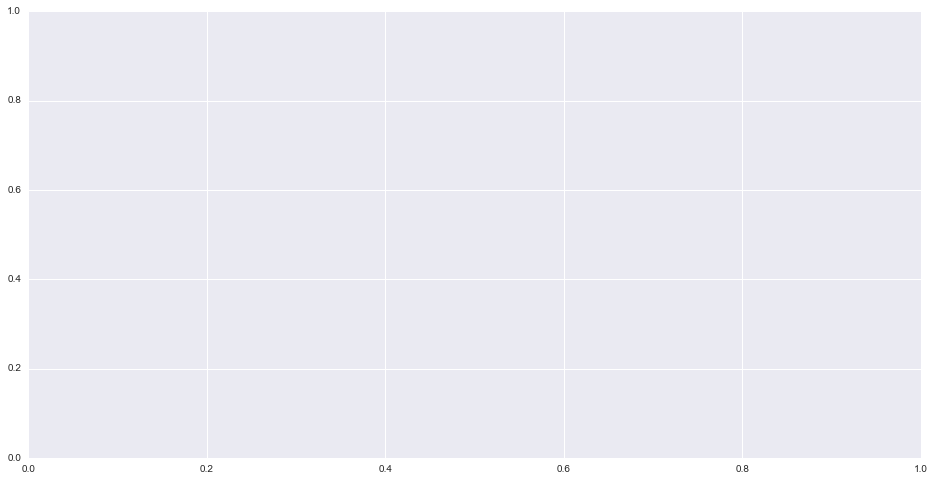

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
final.plot(kind='scatter',x='opening_weekend_take',y='pred_opening_weekend_take',figsize=[16,8])
plt.plot(final.opening_weekend_take, final.opening_weekend_take)